In [1]:
%autosave 60

import tensorflow as tf
import numpy as np
from tensorflow.contrib.layers import batch_norm, dropout

Autosaving every 60 seconds


Exercise 8
===

Create a DQN to solve the "BipedalWalker-v2" gym.

In [2]:
import gym

env = gym.make("BipedalWalker-v2")
obs = env.reset()
print(obs)

[ 2.74735666e-03 -1.91480014e-05  1.48950197e-03 -1.59998703e-02
  9.18869674e-02 -1.96562964e-03  8.60310689e-01  2.85527421e-03
  1.00000000e+00  3.22923772e-02 -1.96549902e-03  8.53861332e-01
  1.39011598e-03  1.00000000e+00  4.40814108e-01  4.45820212e-01
  4.61422890e-01  4.89550292e-01  5.34102917e-01  6.02461159e-01
  7.09149063e-01  8.85932028e-01  1.00000000e+00  1.00000000e+00]


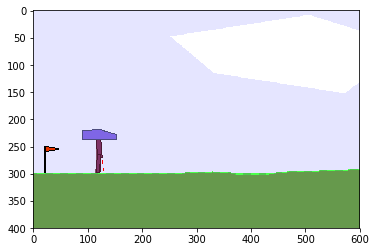

In [3]:
from matplotlib import pyplot as plt

%matplotlib inline

def render_env(env):
    plt.imshow(env.render(mode="rgb_array"))

render_env(env)

In [4]:
print(env.action_space)
print(dir(env.action_space))
print(env.action_space.shape)
print(env.action_space.low)
print(env.action_space.high)

Box(4,)
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'contains', 'from_jsonable', 'high', 'low', 'sample', 'shape', 'to_jsonable']
(4,)
[-1 -1 -1 -1]
[1 1 1 1]


In [5]:
from tensorflow.contrib.layers import fully_connected

neurons_per_layer = [50, 50]
n_outputs = env.action_space.shape[0]

def q_network(X_state, scope):
    current_layer = X_state
    layers = []
    with tf.variable_scope(scope) as scope:
        for neurons in neurons_per_layer:
            current_layer = fully_connected(current_layer, neurons)
        # We use the tanh function because the output ranges from -1 to 1.
        outputs = fully_connected(current_layer, n_outputs, activation_fn=tf.nn.tanh)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name)]: var for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [6]:
print(obs.shape)

(24,)


In [7]:
X_state = tf.placeholder(tf.float32, shape=[None, obs.shape[0]])
actor_q_values, actor_vars = q_network(X_state, "q_networks/actor")
critic_q_values, critic_vars = q_network(X_state, "q_networks/critic")

copy_ops = [actor_var.assign(critic_vars[var_name])
            for var_name, actor_var in actor_vars.items()]
copy_critic_to_actor = tf.group(*copy_ops)

In [8]:
X_action = tf.placeholder(tf.int32, shape=[None])
# This contains the Q-value for the actor's chosen action.
q_value = tf.reduce_sum(critic_q_values * tf.one_hot(X_action, n_outputs), axis=1, keep_dims=True)

In [10]:
# The Actor's reward + future discounted estimated Q-value.
y = tf.placeholder(tf.float32, shape=[None, 1])
cost = tf.reduce_mean(tf.square(y - q_value))
global_step = tf.Variable(0, trainable=False, name="global_step")
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
training_op = optimizer.minimize(cost, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [12]:
from collections import deque

replay_memory_size = 10000
replay_memory = deque([], maxlen=replay_memory_size)

def sample_memory(batch_size):
    indices = rnd.permuation(len(replay_memory))[:batch_size]
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for idx in indices:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return (cols[0], cosl[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1))


In [13]:
# epsilon greed algorithm to explore the state-action space of the environment at the beginning.
def epsilon_greedy(q_values, step):
    eps_min = 0.05 # At the start 5% of the time the actor will choose the greedy action.
    eps_max = 1.0 # Once it has finished exploring, the actor will choose the greedy action 100% of the time.
    eps_decay_steps = 50000
    
    epsilon = max(eps_min, eps_max - (eps_max - eps_min) * step / eps_decay_steps)
    if rnd.rand() < epsilon:
        return rnd.randin(n_output)
    else:
        return np.argmax(q_values) # The greedy/optimal action is the one with the highest estimate Q-value.

In [16]:
import os

n_steps = 100000
# Start training the critic DQN after 1000 game iterations.
# This has to be a lot bigger than the batch_size defined below.
training_start = 1000
training_interval = 3 # Run a training step every 3 game iterations start training_start.
save_steps = 50
copy_steps = 25 # Copy the critic to the actor every 25 training steps.
discount_rate = 0.95
batch_size = 50
iteration = 0
checkpoint_path = "./BipedalWalker-v2.ckpt"
done = True # Environment needs to be reset

with tf.Session() as sess:
    if os.path.isfile(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        if done:
            obs = env.reset()
            state = preprocess_observation(obs)
        
        # Actor evaluates what to do
        q_values = actor_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greed(q_values, step)
        
        # Actor takes action
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)
        
        # Memorise action.
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state
        
        if iteration < training_start or iteration % training_iterval != 0:
            continue
        
        # Train the critic.
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = actor_q_values.eval(feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        # Calculate the Actor's reward + future discounted estimated Q-value.
        y_val = rewards + continues * discount_rate * max_next_q_values
        training_op.run(feed_dict={X_state: X_state_val,
                                  X_action: X_action_val,
                                  y: y_val})
        
        if step % copy_steps == 0:
            copy_critic_to_actor.run()
        
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

NameError: name 'preprocess_observation' is not defined